## Analyzing Police Logs - City of Brockton, MA


In [1]:
import pandas as pd
import numpy as np
import tabula
import re

import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

import os
from os import listdir
from os.path import isfile, join

** Gather Data **

In [2]:
def fetch_logs(month, year, dir='logs'):
    url = "http://www.brocktonpolice.com/wp-content/uploads/{}/{}/".format(year, month)    
    folder_location = r'{}/{}'.format(dir, year)
    if not os.path.exists(folder_location):os.mkdir(folder_location)
    
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")     
    for link in soup.select("a[href$='.pdf']"):
        # Name the pdf files using the last portion of each link which are unique in this case
        filename = os.path.join(folder_location,link['href'].split('/')[-1])
        print('Downloading {}...'.format(filename)) # TODO: remove, testing purpose
        with open(filename, 'wb') as f:
            f.write(requests.get(urljoin(url,link['href'])).content)

def parse_files(path):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    calls = pd.DataFrame(columns=call_columns)
    
    for i in range(len(files)):
        file = files[i]
        if not is_valid_file(file):
            continue
        date = file.split(".")[0]
        print("Parsing: {}... {}/{}".format(path + file, i, len(files))) # TODO: remove, testing purpose
        pages = tabula.read_pdf(path + file, pages='all')
        file_calls = parsePages(pages)
        file_calls['Date'] = date
        calls = calls.append([file_calls], ignore_index = True) 
    
    return calls

** Utils **

In [3]:
def get_call_types(path):
    with open(path) as f:
        return f.read().splitlines()
    
def is_valid_file(filename):
    pattern = re.compile("^(\d{8}.pdf)$")
    return bool(pattern.match(filename))
    
def get_call_number(str):
    return str[:-4]

def get_call_time(str):
    return str[-4:]

def is_new_call(str):
    pattern = re.compile("^(\d\d-[\d]+)$")
    return bool(pattern.match(str))

def get_reason_action(text):
    for type in call_types:
        updated_type = type.strip().lower()
        res = re.search(r'\b({})\b'.format(updated_type), text.lower())
        if res != None:
            action = text[len(updated_type):]
            return (type, action.strip())
    return None  

def get_hour(dateTime):
    return dateTime.hour

def get_month(dateTime):
    return dateTime.month

def get_dayOfWeek(dateTime):
    return dateTime.weekday()

** Parsing **

In [4]:
def parsePages(pages):
    page_columns = ['Column', 'Value', 'Action']
    short_page_columns = ['Column', 'Value/Action']
    calls = pd.DataFrame(columns=call_columns)
    
    for i in range(len(pages)):
        page = pages[i]
        last_call = None
        is_short_page = False
        
        if 'Unnamed: 0' in page:
            page.drop('Unnamed: 0', axis=1, inplace=True) # provides no data

        if len(page.columns) < 2 or len(page.columns) > 3:
            continue
            
        if len(page.columns) == 2:
            is_short_page = True
            
        columns = short_page_columns if is_short_page else page_columns    

        # save current columns
        prev_columns = page.columns.tolist()
        page.columns = columns

        # append original columns as an entry 
        df_prev_columns = pd.DataFrame([prev_columns], columns=columns)
        updated_page = page.append(df_prev_columns, ignore_index=True)
        updated_page.fillna("None", inplace=True)

        entry_values = None

        for index, row in updated_page.iterrows():
            column_name = str(row[columns[0]])
            column_value = row[columns[1]]

            if is_new_call(column_name):
                if index > 0 and entry_values != None:
                    # add previous call as entry before we parse new call
                    call = pd.DataFrame([entry_values.values()], columns=call_columns)
                    calls = calls.append([call], ignore_index = True) 
                    last_call = call

                entry_values = {column: None for column in call_columns}
                entry_values['Call Number'] = get_call_number(column_name)
                entry_values['Call Time'] = get_call_time(column_name)
                
                if is_short_page:
                    # reason and action values combined in short pages
                    reason_action = get_reason_action(column_value)
                    
                    if reason_action != None:
                        entry_values['Reason'], entry_values['Action'] = reason_action
                    else:    
                        # unable to split reason and action
                        entry_values['Reason'] = column_value
                        entry_values['Action'] = column_value
                else:
                    action = row[columns[2]]
                    entry_values['Reason'] = column_value
                    entry_values['Action'] = action
                    
                entry_values['Page'] = i
            else:
                # TODO: find better approach to parsing pages where first row isn't call number    
                if entry_values == None or entry_values['Call Number'] == None:
                    continue
                    
                filter_column_name = column_name.replace(":", "")
                if filter_column_name in entry_values:
                    entry_values[filter_column_name] = column_value
    return calls               

In [5]:
call_types = get_call_types('call_types')
call_columns = ['Call Number', 'Call Time', 'Call Taker', 'Reason', 'Action', 'ID', 'Location/Address', 'Page', 'Date']
weekday_map = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}

### Exploratory Data Analysis

In [6]:
# fetch_logs('05', '2020')
# calls = parse_files('logs/2020/')

# read data from cache
calls = pd.read_pickle('cached_calls.pkl')

In [7]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7104 entries, 0 to 7103
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Call Number       7104 non-null   object        
 1   Call Time         7104 non-null   object        
 2   Call Taker        6252 non-null   object        
 3   Reason            7104 non-null   object        
 4   Action            7104 non-null   object        
 5   ID                4361 non-null   object        
 6   Location/Address  4694 non-null   object        
 7   Page              7104 non-null   object        
 8   Date              7104 non-null   object        
 9   timeStamp         7104 non-null   datetime64[ns]
 10  Hour              7104 non-null   int64         
 11  Month             7104 non-null   int64         
 12  Day of Week       7104 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(10)
memory usage: 721.6+ KB


In [41]:
calls['timeStamp'] = pd.to_datetime(calls['Date'] + ' ' + calls['Call Time'])
calls['Hour'] = calls['timeStamp'].apply(lambda time: time.hour)
calls['Month'] = calls['timeStamp'].apply(lambda time: time.month)
calls['Day of Week'] = calls['timeStamp'].apply(lambda time: time.dayofweek)
calls['Day of Week'] = calls['Day of Week'].map(weekday_map)

** Top 5 officers reporting to incidents ** 

In [43]:
calls['ID'].value_counts().head(5)

Patrolman Richard J Gaucher      188
Patrolman Alexander C Burrell     84
Patrolman David F Santos          81
Patrolman Callie H Royster Jr     75
Patrolman Michael j Micciche      70
Name: ID, dtype: int64

** Top 5 incident locations/address **

In [45]:
top_locations = calls['Location/Address'].value_counts().head(5)
top_locations_list = top_locations.index.tolist()
top_locations

[BRO 7484] 917 MONTELLO ST    37
[BRO 31] 470 FOREST AVE       37
[BRO 5328] 715 BELMONT ST     23
[BRO 45] 7 COMMERCIAL ST      21
105 BELAIR ST                 20
Name: Location/Address, dtype: int64

** Most common actions **

In [46]:
top_actions = calls['Action'].value_counts().head(5)
top_actions

Taken/Referred to Other Agency    1113
Matter Settled                    1108
False 911 Call                     569
FALSE ALARM                        479
Report taken                       429
Name: Action, dtype: int64

** Most common incidents **

In [47]:
top_reasons = calls['Reason'].value_counts().head(5)
top_reasons_list = top_reasons.index.tolist()
top_reasons

911 Transfer to Ambulance    1193
DISTURBANCE                   730
911 Verify Call               660
MOTOR VEHICLE STOP            634
Alarm Telephone               523
Name: Reason, dtype: int64

** Most common action taken per incident type ** 

In [48]:
resolve_df = calls.groupby('Reason')['Action'].apply(lambda x: x.value_counts().index[0]).reset_index()
resolve_df

,Reason,Action
0,911 False Call Cancelled,911 False Call Cancelled
1,911 False Call False 911 Call,911 False Call False 911 Call
2,911 False Call Investigated,911 False Call Investigated
3,911 Hang Up,False 911 Call
4,911 Transfer Out of Town,Taken/Referred to Other Agency
...,...,...
124,Unknown Emergency,Matter Settled
125,Unwanted Guest Disturbance,Matter Settled
126,Unwanted Guest Drunk,Matter Settled
127,Unwanted Guest Family,Report taken


** Most common incident by location/address **

In [86]:
location_incident_df = calls.groupby('Location/Address')['Reason'].apply(lambda x: x.value_counts().index[0]).reset_index()
location_incident_df['Count'] = calls.groupby('Location/Address')['Reason'].apply(lambda x: x.value_counts()[0]).values
location_incident_df.sort_values(by='Count', ascending=False, inplace=True)
location_incident_df.head(20)

,Location/Address,Reason,Count
2888,[BRO 7484] 917 MONTELLO ST,MISSING PERSON,28
2352,[BRO 31] 470 FOREST AVE,TRAFFIC CONTROL,22
102,105 BELAIR ST,Community Police Call,20
2561,[BRO 5328] 715 BELMONT ST,TRAFFIC CONTROL,19
2150,[BRO 1910] 53 PLYMOUTH ST,Community Police Call,12
490,198 CENTRE ST @ 99 PLYMOUTH ST,MOTOR VEHICLE STOP,9
1352,700 BELMONT ST,Alarm Telephone,9
1232,61 BRADLEY AVE,DISTURBANCE,8
281,1380 MAIN ST,Community Police Call,8
2110,[BRO 1652] 54 N MAIN ST,DISTURBANCE,8


In [50]:
# most common incident for the top location with most incidents
top_locations_df = calls[calls['Location/Address'].isin(top_locations_list)]
top_locations_incidents = top_locations_df.groupby('Location/Address')['Reason'].apply(lambda x: x.value_counts().index[0]).reset_index()
top_locations_incidents

,Location/Address,Reason
0,105 BELAIR ST,Community Police Call
1,[BRO 31] 470 FOREST AVE,TRAFFIC CONTROL
2,[BRO 45] 7 COMMERCIAL ST,See the Complainant
3,[BRO 5328] 715 BELMONT ST,TRAFFIC CONTROL
4,[BRO 7484] 917 MONTELLO ST,MISSING PERSON


### Data Visualization 

In [51]:
import seaborn as sns
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
%matplotlib inline

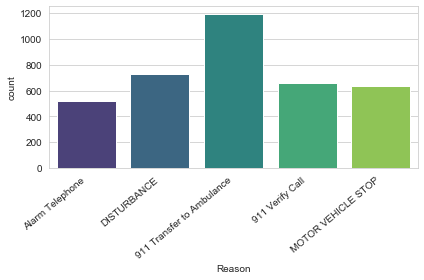

In [52]:
top_reasons_df = calls[calls['Reason'].isin(top_reasons_list)]
ax = sns.countplot(x='Reason',data=top_reasons_df,palette='viridis')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

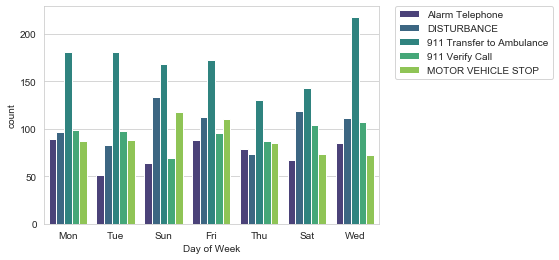

In [53]:
sns.countplot(x='Day of Week',data=top_reasons_df,hue='Reason',palette='viridis')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

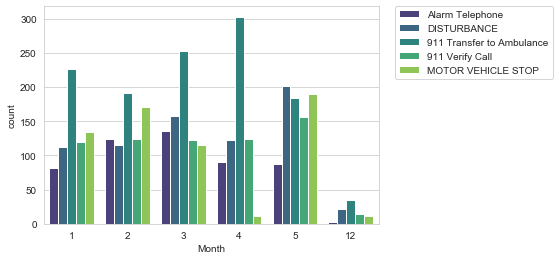

In [54]:
sns.countplot(x='Month',data=top_reasons_df,hue='Reason',palette='viridis')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# TODO: parse all months of year

In [55]:
dayHour = top_reasons_df.groupby(by=['Day of Week','Hour']).count()['Reason'].unstack()
dayHour.head()

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Day of Week,,,,,,,,,,,,,,,,,,,,,
Fri,14,20,14,7,8,14,28,20,17,23,...,40,33,27,43,21,37,30,15,40,25
Mon,25,19,10,4,8,21,23,19,25,29,...,24,28,20,29,24,31,24,34,31,18
Sat,14,11,21,5,7,4,10,5,25,31,...,15,29,36,28,22,32,22,24,34,27
Sun,30,33,9,16,6,4,11,10,21,16,...,13,17,7,40,51,61,29,25,24,6
Thu,25,19,14,7,5,5,11,16,8,12,...,19,27,24,38,28,28,16,32,20,12


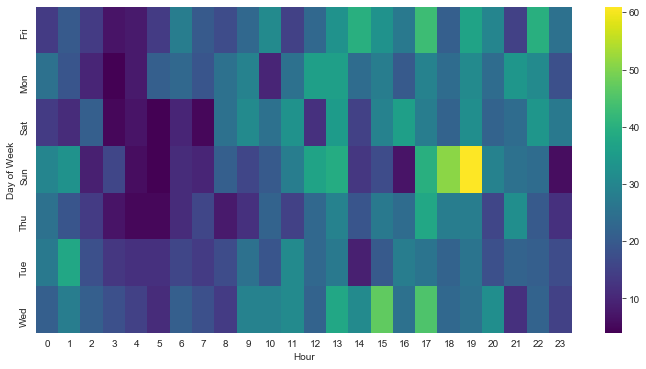

In [56]:
plt.figure(figsize=(12,6))
sns.heatmap(dayHour,cmap='viridis')